## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

## Goals
You are given two files: ‘TCGame_Env.py’ and ‘TicTacToe_Agent.ipynb’. The first one is the environment file and the second one is the agent file. You use the environment that is created in TCGame_Env.py to write the learning algorithm.
 
You need to accomplish following in this assignment:
* Create an MDP for Numerical Tic-Tac-Toe game. The basic framework for this is:
* Initialise the state
* Define the action space for each state. (Be careful in defining actions. The actions are not the same for each state)
* Define the winning states: the sum of three numbers in a row, column or diagonal is 15.
* Define the terminal states (win,tie,loss)
* Build the reward structure as below:
        +10 if the agent wins (makes 15 points first)
        -10 if the environment wins
        0 if the game ends in a draw (no one is able to make 15 and the board is filled up)
        -1 for each move agent takes
* Define a step function which takes in an input of the agent’s action and state; and outputs the next state and reward. (Make sure you incorporate environment’s move in the next state).
* For your reference: TCGame_Env.py file is provided with a basic structure of the code. The functions (and the comments) will provide an intuition of how the MDP would be formulated. Codes of a few functions are also provided to give you more sense on how to proceed with the MDP. Note: Using this framework is not compulsory, you can create your own framework and functions as well.
* Build an agent that learns the game by Q-Learning. You can choose the hyperparameters (epsilon (decay rate), learning-rate, discount factor) of your choice. For that, you can train the model iteratively to obtain a good combination of hyperparameters. You won’t be evaluated on your choice of the hyperparameters. You need to submit only the final model. 
* While updating the Q-values, if the next state is a terminal state, then the Q-values from that state are 0. (No action is possible from that state)
* For a 64-bit system with 8GB RAM, it takes ~30 minutes to run 5Mn episodes.
* Q-values convergence- check whether Q-values learnt by the agent have converged or not. Sample 4 state-action pairs and plot it with the number of episodes to understand the convergence.

#### Importing libraries

In [1]:
# Import the necessory libraries
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
from matplotlib import pyplot as plt

In [2]:
# defining object for the Tictac toe environment
env = TicTacToe()

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [6]:
# Print board position
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [7]:
# Print all valid actions
valid_actions(env.state)


[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence

In [9]:
# Initialising Q_dictionary and States_track
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [10]:
# Initialising states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [11]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# definign a function for saving states tracking

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action]) 

#### Define hyperparameters

In [13]:
#Defining parameters for the training

EPISODES = 50000

# learning rate
LR = 0.01    

# discount factor
GAMMA = 0.9                

max_epsilon = 1.0
min_epsilon = 0.001

# epsilon decay rate
decay_rate = 0.001        
threshold = 200       
policy_threshold = 300   

In [14]:
initialise_tracking_states()

## Build an agent that learns the game by Q-Learning

In [15]:
import time 
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    # adding the current state to dictionary
    add_to_dict(curr_state)  

    while done != True:  
        curr_state1 = Q_state(curr_state)
        
        # applying epislon method
        curr_action = epsilon_greedy(curr_state, episode)   
        next_state, reward, done = env.step(curr_state, curr_action) # getting reward
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)

        # Updating the rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
            
            #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to the next state
        curr_state = next_state
        
    #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')

    #at every 300th episodes, the Q-dict will be saved
    if ((episode+1)% policy_threshold) == 0:  
        save_obj(Q_dict,'Policy_Q_dict')  
        

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Policy_Q_dict')

In [16]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.0067431917040075,
              (0, 3): -1.006733249415927,
              (0, 5): -1.0067426705502807,
              (0, 7): -1.006740931877634,
              (0, 9): -1.006743370560281,
              (1, 1): -1.00674125963917,
              (1, 3): -1.006742286872295,
              (1, 5): -1.0067264391676298,
              (1, 7): -1.0067298618762057,
              (1, 9): -1.0067408730024168,
              (2, 1): -1.0067402712690683,
              (2, 3): -1.006740978853971,
              (2, 5): -1.0067231122352858,
              (2, 7): -1.0067420897220603,
              (2, 9): -1.0067232694107824,
              (3, 1): -1.0067374501105693,
              (3, 3): -1.0067235355387105,
              (3, 5): -1.006723035694626,
              (3, 7): -1.0067393099702828,
              (3, 9): -1.0067275978552308,
              (4, 1): -1.006722191190072,
              (4, 3): -1.0067318269032999,
              (4, 5): -1

### Checking whether Q-values learnt by the agent have converged or not

<function matplotlib.pyplot.show(close=None, block=None)>

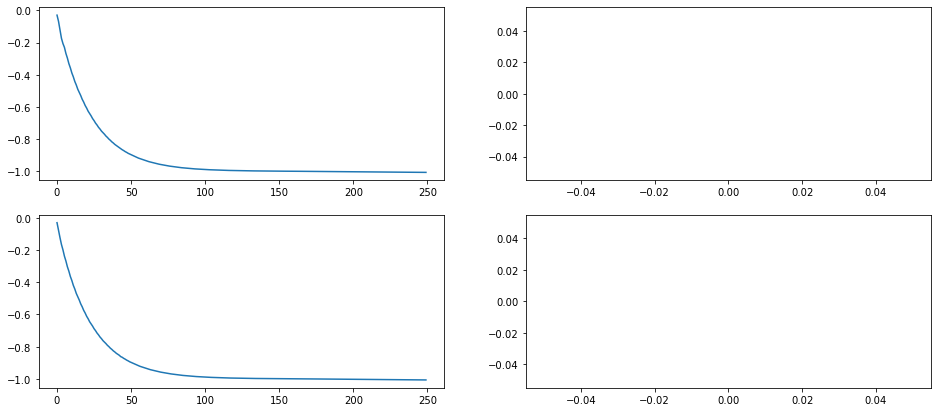

In [17]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-1-x-x-x-x'][(7,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-x-x-5-7-x'][(8,2)]))
plt.show




### Epsilon - decay check

In [18]:
time = np.arange(0,50000)
epsilon = []
for i in range(0,50000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

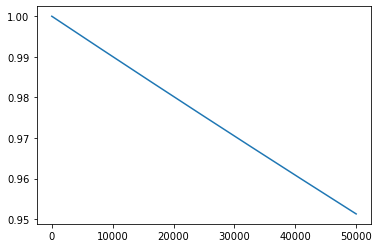

In [19]:
plt.plot(time, epsilon)
plt.show()